真正用于生产可以设计多级模型，第一步模型用于检测异常话单，第二步模型进一步分类错误类型，第三步模型尝试预测出产生错误的具体环节或步骤。

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['font.sans-serif'] = ['SimHei'] 
rcParams['axes.unicode_minus'] = False  
from sklearn.model_selection import GridSearchCV, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
import shap

# 读取数据
file_path = 'E://RN78_PE12.xlsx'
data = pd.read_excel(file_path)

# 筛选出两类样本
condition1 = data['ERRORCODE'] == "(源计费事件.动态漫游号 match ['13900','8613900','1374','861374','1344','861344'])"
data1 = data[condition1]
data2 = data[~condition1]  

In [51]:
data2  
#TIME_DIFF = PROCESSTIME-STARTTIME-DURATION 单位是秒数，取整

,ROAMTYPE,VREGION,HREGION,HMANAGE,OTHERVREGION,OTHERHREGION,OTHERMANAGE,OTHERNETTYPE,STARTTIME,DURATION,ROAMFEE,TOLLFEE,ERRORCODE,DEVICETYPE,PROCESSTIME,TIME_DIFF
50,0,313,313,1.311,668,668,2.200,P,2024-07-01 09:23:35,23,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 09:27:07,189
51,0,313,313,1.311,668,668,2.200,P,2024-07-01 09:25:26,16,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 09:27:14,92
52,0,313,313,1.311,668,668,2.200,P,2024-07-01 09:30:46,46,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 09:33:57,145
53,0,313,313,1.311,668,668,2.200,P,2024-07-01 11:36:47,57,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 11:40:27,163
54,0,313,313,1.311,668,668,2.200,P,2024-07-01 14:57:38,29,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 15:00:06,119
55,0,313,313,1.311,668,668,2.200,P,2024-07-01 14:57:56,43,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 15:00:01,82
56,0,335,335,1.311,668,668,2.200,P,2024-07-01 15:26:33,42,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 15:29:18,123
57,0,335,335,1.311,668,668,2.200,P,2024-07-01 15:53:07,42,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 15:54:49,60
58,0,313,313,1.311,668,668,2.200,P,2024-07-01 17:05:39,22,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 17:08:07,126
59,0,335,335,1.311,668,668,2.200,P,2024-07-01 17:34:59,38,0.0,0.0,"目计费事件.特殊通话类型 match ['8163','8169']and 目计费事件.通话...",131,2024-07-01 17:37:40,123


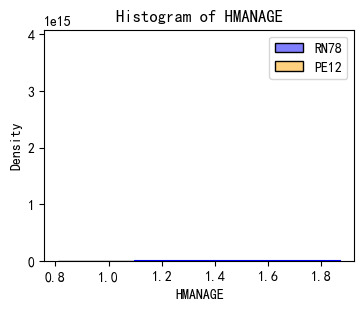

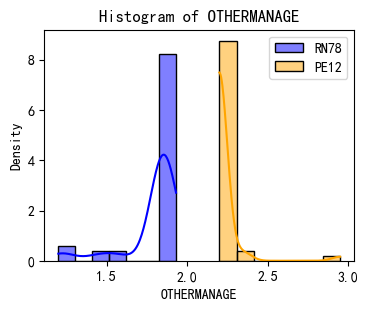

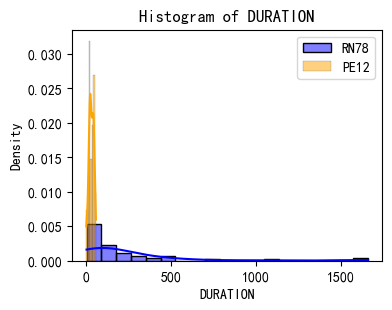

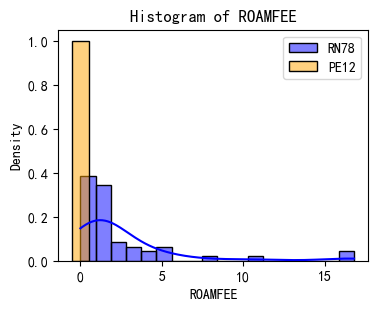

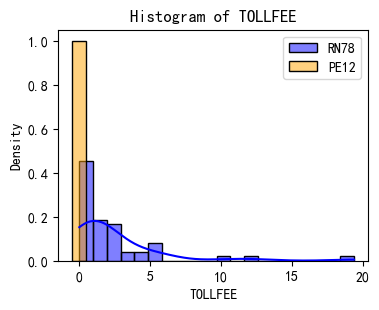

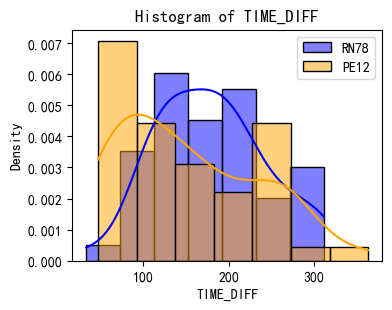

In [48]:
# 绘制数值型特征的直方图
numeric_features = ['HMANAGE', 'OTHERMANAGE', 'DURATION', 'ROAMFEE', 'TOLLFEE', 'TIME_DIFF']

for feature in numeric_features:
    plt.figure(figsize=(4, 3))

    sns.histplot(data1[feature], color='blue', kde=True, label='RN78', stat="density", common_norm=False)
    sns.histplot(data2[feature], color='orange', kde=True, label='PE12', stat="density", common_norm=False)
    
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

    plt.show()

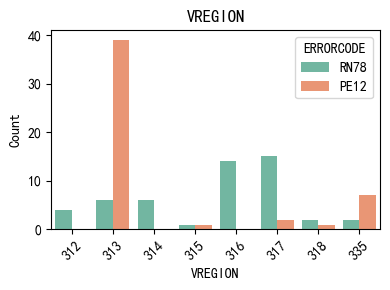

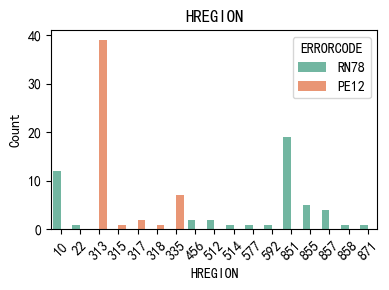

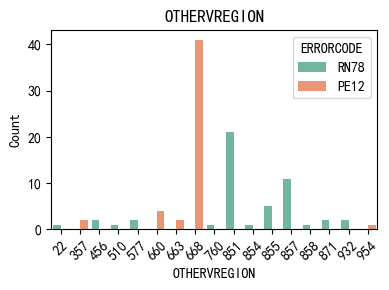

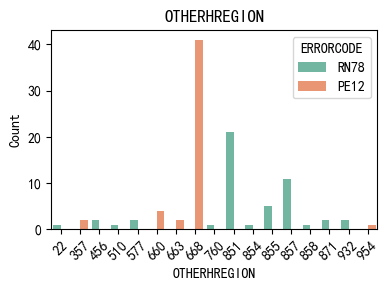

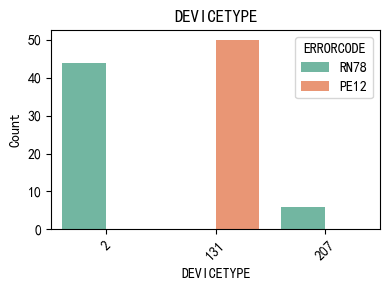

In [49]:
# 绘制类别型特征的计数图
categorical_features = ['VREGION', 'HREGION', 'OTHERVREGION', 'OTHERHREGION', 'DEVICETYPE']

data1['ERRORCODE_LABEL'] = 'RN78'
data2['ERRORCODE_LABEL'] = 'PE12'

for feature in categorical_features:
    plt.figure(figsize=(4, 3))
    
    sns.countplot(x=feature, hue='ERRORCODE_LABEL', data=pd.concat([data1, data2]), palette='Set2')
    
    plt.title(f'{feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='ERRORCODE', loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [4]:
file_path = 'E://RN78_PE12.xlsx'
data = pd.read_excel(file_path)

features = ['VREGION', 'HREGION', 'OTHERVREGION', 'OTHERHREGION', 'DEVICETYPE', 'HMANAGE', 'OTHERMANAGE', 'DURATION', 'ROAMFEE', 'TOLLFEE', 'TIME_DIFF']
target_error_code =  "(源计费事件.动态漫游号 match ['13900','8613900','1374','861374','1344','861344'])"

data['Target'] = data['ERRORCODE'].apply(lambda x: 1 if x == target_error_code else 0)

X = data[features]
y = data['Target']

X = pd.get_dummies(X, columns=['VREGION', 'HREGION', 
                               'OTHERVREGION', 'OTHERHREGION', 'DEVICETYPE'
                             ])

In [5]:
X

,HMANAGE,OTHERMANAGE,DURATION,ROAMFEE,TOLLFEE,TIME_DIFF,VREGION_312,VREGION_313,VREGION_314,VREGION_315,...,OTHERHREGION_854,OTHERHREGION_855,OTHERHREGION_857,OTHERHREGION_858,OTHERHREGION_871,OTHERHREGION_932,OTHERHREGION_954,DEVICETYPE_2,DEVICETYPE_131,DEVICETYPE_207
0,1.250,1.571,43,0.6,0.32,124,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,1.851,1.851,343,3.6,2.32,276,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
2,1.851,1.851,120,1.2,0.80,140,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1.100,1.851,742,7.8,4.96,184,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,1.100,1.931,1576,16.2,10.52,164,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.311,2.351,0,0.0,0.00,82,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,1.311,2.200,16,0.0,0.00,87,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
97,1.311,2.200,35,0.0,0.00,59,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
98,1.311,2.200,25,0.0,0.00,363,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [8]:
classifiers = {
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }),
    'CatBoost': (CatBoostClassifier(random_state=42, verbose=0), {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7]
    })
}

# 10折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, (clf, param_grid) in classifiers.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kf, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_clf = grid_search.best_estimator_
    print(f'Best parameters found for {name}: {grid_search.best_params_}')
    
    y_pred = cross_val_predict(best_clf, X, y, cv=kf)
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    
    print(f'Accuracy with 10-fold CV: {accuracy:.4f}')
    print(f'Precision with 10-fold CV: {precision:.4f}')
    print(f'Recall with 10-fold CV: {recall:.4f}')
    print(f'F1 Score with 10-fold CV: {f1:.4f}')
    print("\nClassification Report:\n", classification_report(y, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))



Training Decision Tree...
Best parameters found for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy with 10-fold CV: 0.9900
Precision with 10-fold CV: 0.9902
Recall with 10-fold CV: 0.9900
F1 Score with 10-fold CV: 0.9900

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
 [[50  0]
 [ 1 49]]

Training Random Forest...
Best parameters found for Random Forest: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy with 10-fold CV: 1.0000
Precision with 10-fold CV: 1.0000
Recall with 10-fold CV: 1.0000
F1 Score with 10-fold CV: 1.0000

Classification Report:
               precision    recall  f1-

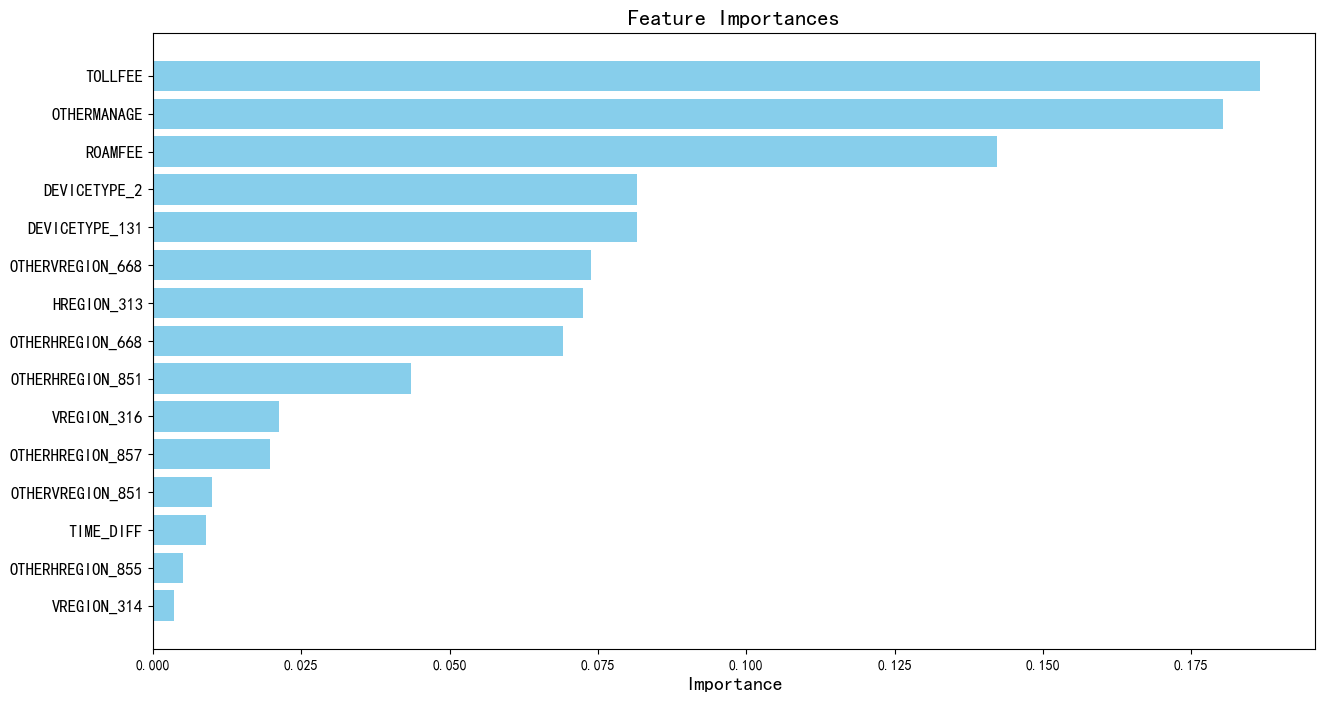

In [27]:
#使用随机森林特征分析
param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

clf = RandomForestClassifier(random_state=42)

kf = KFold(n_splits=20, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kf, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

best_clf = grid_search.best_estimator_

importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]

indices = indices[importances[indices] > 0]
importances = importances[indices]
features = X.columns[indices]

plt.figure(figsize=(15, 8))
plt.title("Feature Importances", fontsize=16)
plt.barh(range(len(importances)), importances, color="skyblue", align="center")
plt.yticks(range(len(importances)), features, fontsize=12)
plt.gca().invert_yaxis()  
plt.xlabel('Importance', fontsize=14)
plt.show()

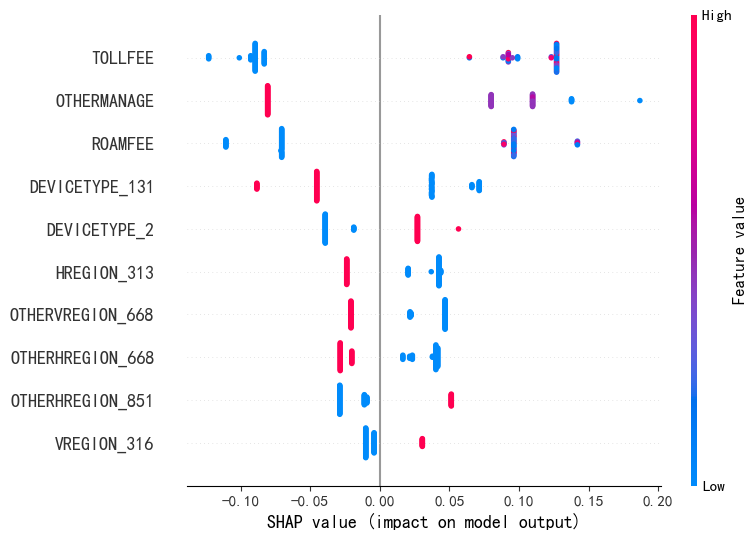

In [31]:
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X)

# 绘制 SHAP 摘要图
shap.summary_plot(shap_values[1], X, plot_type="dot", max_display=10)

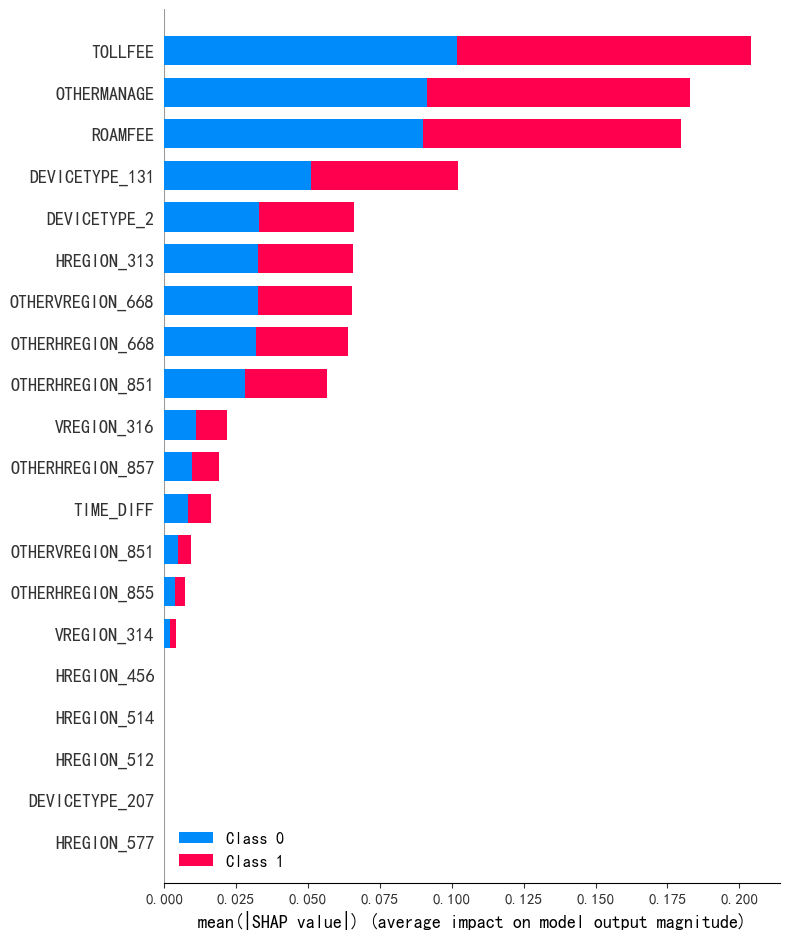

In [32]:
shap.summary_plot(shap_values, X)

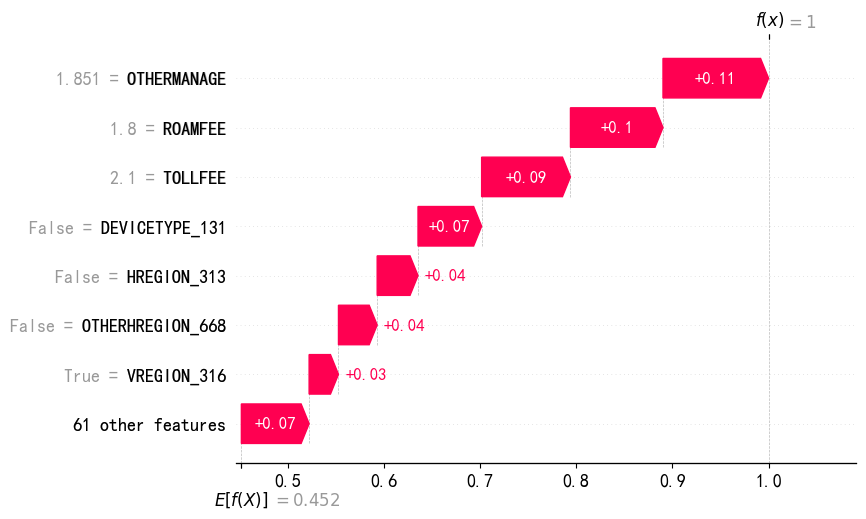

In [36]:
# 可视化 SHAP 值（单个样本）
shap.initjs()
sample_index = 5  
shap.waterfall_plot(shap.Explanation(values=shap_values[1][sample_index, :],
                                     base_values=explainer.expected_value[1],
                                     data=X.iloc[sample_index, :],
                                     feature_names=X.columns),
    max_display=8)